In [1]:
import matplotlib.pyplot as plt

In [2]:
from PIL import Image

In [3]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
from tensorflow.keras.models import Model

In [5]:
from tensorflow.keras.layers import Conv2D, Input, Concatenate, MaxPooling2D, Conv2DTranspose

In [6]:
import numpy as np

In [7]:
import os

In [8]:
import cv2

In [9]:
train_fpath='Dataset/images/'
train_masks_fpath='Dataset/masks/'

In [10]:
print("No. of images =",len(os.listdir(train_fpath)))
print("No. of image masks =",len(os.listdir(train_masks_fpath)))

No. of images = 267
No. of image masks = 267


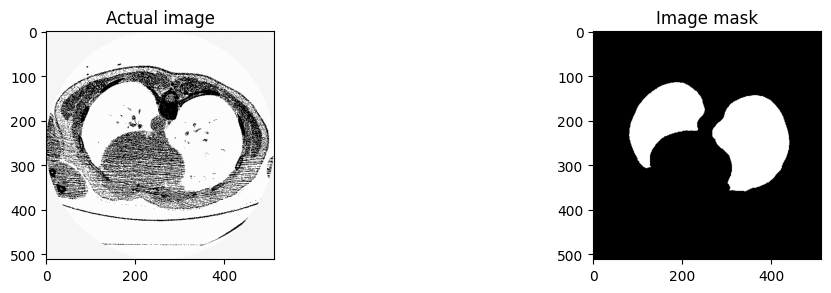

In [11]:
def plot_img_and_mask(id):
    img = cv2.imread(train_fpath + id + '.tif')
    img_mask = cv2.imread(train_masks_fpath + id + '.tif')
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1,title='Actual image')
    plt.imshow(img)
    plt.subplot(1,3,3,title='Image mask')
    plt.imshow(img_mask)
    
plot_img_and_mask('ID_0066_Z_0141')

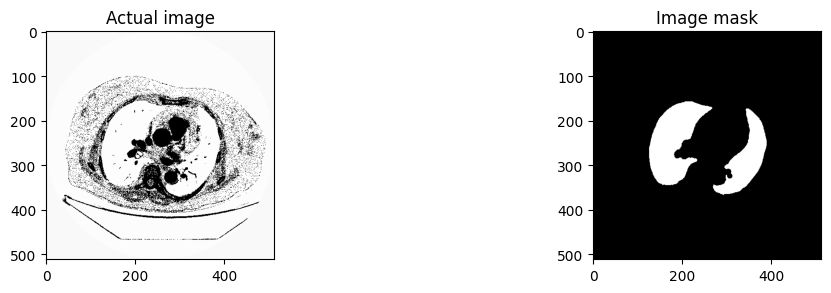

In [12]:
plot_img_and_mask('ID_0202_Z_0098')

- Initialize training data

In [13]:
def initialize_img_data(folder):
    lst=[] 
    for image in os.listdir(folder):
        img= cv2.imread(folder+"/"+image, cv2.IMREAD_GRAYSCALE)
        img_array=Image.fromarray(img)
        resize_img = img_array.resize((128 , 128))
        norm_img=np.array(resize_img)/255
        img_array = norm_img.reshape((128,128,1))
        lst.append(img_array)
    return lst
    
X = initialize_img_data(train_fpath)
y = initialize_img_data(train_masks_fpath)


In [14]:
print(len(os.listdir(train_fpath)),len(X),len(y))
print(X[0].shape,y[0].shape)

267 267 267
(128, 128, 1) (128, 128, 1)


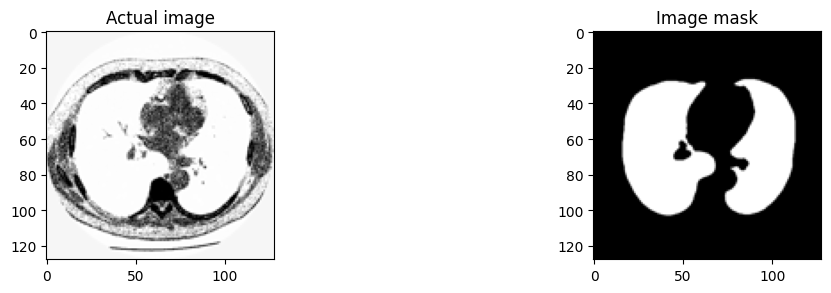

In [15]:
plt.figure(figsize=(10,10))
plt.subplot(1,3,1,title='Actual image')
plt.imshow(X[10],cmap="gray")

plt.subplot(1,3,3,title='Image mask')
plt.imshow(y[10],cmap="gray")

In [16]:
X = np.array(X)
y = np.array(y)

In [17]:
x_train = X[:200]
y_train = y[:200]

x_test = X[200:]
y_test = y[200:]

In [18]:
def create_model():
    inputs = Input(shape=(128, 128, 1))

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = Concatenate()([u9, c1]) 
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [19]:
model = create_model()

In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 8)  80          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 8)    0           ['conv2d_1[0][0]']           

In [21]:
x_train.shape

(200, 128, 128, 1)

In [22]:
early_stop = EarlyStopping(patience=5)
check_point = ModelCheckpoint('model.hdf5',save_best_only=True)

In [23]:
can_train = False

In [24]:
if can_train:
    history = model.fit(x_train, y_train, epochs=200, callbacks=[early_stop,check_point])
    model.save("Lung-Semantic-Segmentation-Model.keras")
    with open("Lung-Semantic-Segmentation-History.pickle", "wb") as fs:
        pickle.dump(history.history, fs)
    history = history.history
else:
    model = load_model("Lung-Semantic-Segmentation-Model.keras")
    with open("Lung-Semantic-Segmentation-History.pickle", "rb") as fs:
        history = pickle.load(fs)

NameError: name 'load_model' is not defined

In [ ]:
pred_test = model.predict(x_test, verbose=1)

In [ ]:
x_test = np.squeeze(x_test,axis=-1)
pred_test = np.squeeze(pred_test,axis=-1)

print(x_test.shape, pred_test.shape)

In [ ]:
plt.figure(1 , figsize = (15, 9))
n = 0 
for i in range(4):
    n += 1 
    r=[i]
    plt.subplot(2, 2, n)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    plt.imshow(x_test[r[0]], cmap="gray")
    plt.imshow(pred_test[r[0]], alpha=0.5, cmap="Oranges")
    

plt.suptitle("Lung images and the masks predicted by proposed model highlighted in RED")
plt.show()

In [ ]:
plt.figure(1 , figsize = (15, 9))
n = 0 
for i in range(4):
    n += 1 
    r=[i]
    plt.subplot(2, 2, n)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    plt.imshow(x_test[r[0]], cmap="gray")
    plt.imshow(y_test[r[0]], alpha=0.5, cmap="Oranges")
    

plt.suptitle("Lung images and the masks predicted by proposed model highlighted in RED")
plt.show()